In [73]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.axes
## for statistical tests
import scipy
# import statsmodels.formula.api as smf
# import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
## for explainer
# from lime import lime_tabular
import matplotlib.ticker as plticker
import pickle

In [74]:
#Predit on the test set
dfs = pd.read_csv("train.csv")
dfv = pd.read_csv("validation.csv")

In [75]:
#ENCODING ds

dfs = pd.get_dummies(dfs, columns=['Marital status'])
dfs = pd.get_dummies(dfs, columns=['Application mode'])
dfs = pd.get_dummies(dfs, columns=['Course'])
dfs = pd.get_dummies(dfs, columns=['Previous qualification'])
dfs = pd.get_dummies(dfs, columns=['Nacionality'])
dfs = pd.get_dummies(dfs, columns=["Mother's occupation"])
dfs = pd.get_dummies(dfs, columns=["Father's occupation"])

#DROP AND CREATE
dfs = dfs.drop(["Mother's qualification", "Father's qualification"], axis=1)
dfs["valid_enroll_sem2"] = dfs["Curricular units 2nd sem (enrolled)"] - dfs["Curricular units 2nd sem (approved)"]
dfs["valid_enroll_sem1"] = dfs["Curricular units 1st sem (enrolled)"] - dfs["Curricular units 1st sem (approved)"]
dfs["gap_enroll_valid"] = dfs["valid_enroll_sem1"] - dfs["valid_enroll_sem2"]

#encoding dv
dfv = pd.get_dummies(dfv, columns=['Marital status'])
dfv = pd.get_dummies(dfv, columns=['Application mode'])
dfv = pd.get_dummies(dfv, columns=['Course'])
dfv = pd.get_dummies(dfv, columns=['Previous qualification'])
dfv = pd.get_dummies(dfv, columns=['Nacionality'])
dfv = pd.get_dummies(dfv, columns=["Mother's occupation"])
dfv = pd.get_dummies(dfv, columns=["Father's occupation"])

#DROP AND CREATE
dfv = dfv.drop(["Mother's qualification", "Father's qualification"], axis=1)
dfv["valid_enroll_sem2"] = dfv["Curricular units 2nd sem (enrolled)"] - dfv["Curricular units 2nd sem (approved)"]
dfv["valid_enroll_sem1"] = dfv["Curricular units 1st sem (enrolled)"] - dfv["Curricular units 1st sem (approved)"]
dfv["gap_enroll_valid"] = dfv["valid_enroll_sem1"] - dfv["valid_enroll_sem2"]

# Find the difference in columns between the two datasets
feature_difference_0 = set(dfv) - set(dfs)

# create zero-filled matrix where the rows are equal to the number
feature_difference_df0 = pd.DataFrame(data=np.zeros((dfv.shape[0], len(feature_difference_0))), columns=list(feature_difference_0))
dfs = dfs.join(feature_difference_df0)

#MinMax-Scaler
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(dfs.drop(["Category","Id"], axis=1))
dtf_scaled= pd.DataFrame(X, columns=dfs.drop(["Category","Id"], axis=1).columns)
dtf_scaled["Category"] = dfs["Category"]
dtf_scaled["Id"] = dfs["Id"]
dfs = dtf_scaled

#features selection
df = dfs[["Id",
"Gender",
"Curricular units 2nd sem (approved)", 
"Curricular units 1st sem (approved)",
"valid_enroll_sem2",
"valid_enroll_sem1", 
"gap_enroll_valid",
"Curricular units 2nd sem (grade)",
"Curricular units 1st sem (grade)",
"Age at enrollment",
"Tuition fees up to date",
"Scholarship holder", 
"Course_12",
"Course_7",
"Course_16",
"Application mode_1",
"Application mode_8",
"Application mode_12",
"Mother's occupation_1",
"Mother's occupation_10",
"Father's occupation_1",
"Father's occupation_10",
"Previous qualification_12",
"Previous qualification_3",
"Debtor",
"GDP",
"Inflation rate",
"Unemployment rate",
"Category"]]

# GRAPHS

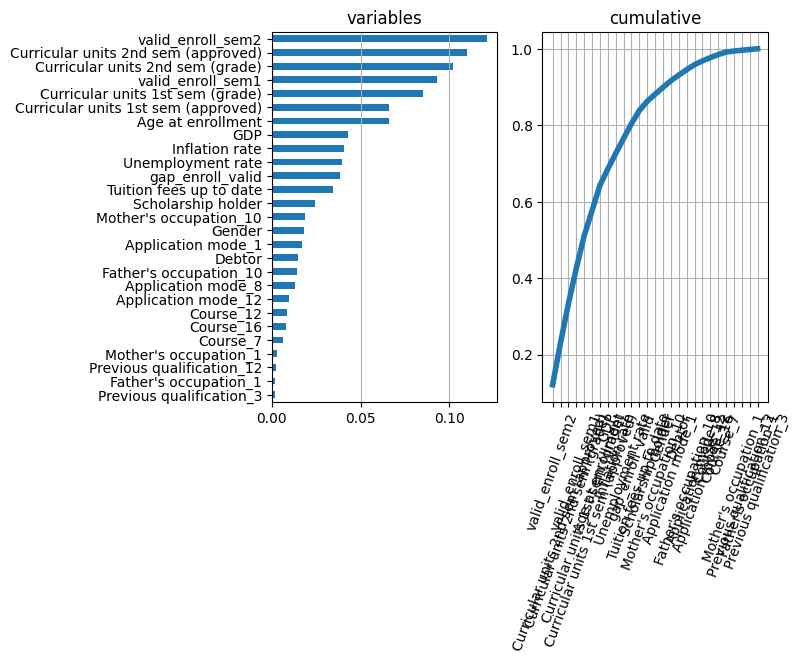

,IMPORTANCE,cumsum
VARIABLE,,
valid_enroll_sem2,0.120867,0.120867
Curricular units 2nd sem (approved),0.110075,0.230942
Curricular units 2nd sem (grade),0.101881,0.332823
valid_enroll_sem1,0.092790,0.425613
Curricular units 1st sem (grade),0.084943,0.510556
Curricular units 1st sem (approved),0.066174,0.576730
Age at enrollment,0.065999,0.642729
GDP,0.042736,0.685465
Inflation rate,0.040548,0.726013


In [76]:
# Plot
X = df.drop(["Category", "Id"], axis=1).values
y = df["Category"].values
feature_names = df.drop(["Category", "Id"], axis=1).columns

model = ensemble.RandomForestClassifier(n_estimators=100,
                      criterion="entropy", random_state=0)
model.fit(X,y)
importances = model.feature_importances_
## Put in a pandas df
dfs_importances = pd.DataFrame({"IMPORTANCE":importances, 
            "VARIABLE":feature_names}).sort_values("IMPORTANCE", 
            ascending=False).nlargest(30,"IMPORTANCE")
dfs_importances['cumsum'] = dfs_importances['IMPORTANCE'].cumsum(axis=0)
dfs_importances = dfs_importances.set_index("VARIABLE")
    
## Plot

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].title.set_text('variables')
dfs_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
dfs_importances[["cumsum"]].plot(kind="line", linewidth=4, legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dfs_importances)), xticklabels=dfs_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()
dfs_importances.head(40)

<AxesSubplot: xlabel='selection', ylabel='features'>

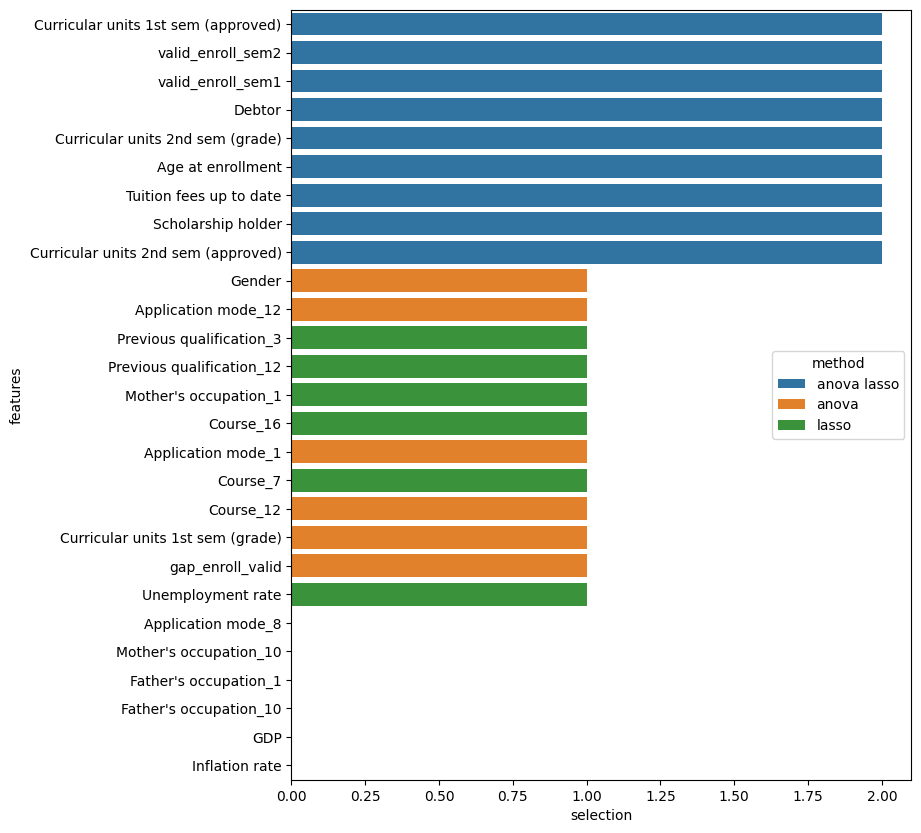

In [77]:
## Anova
selector = feature_selection.SelectKBest(score_func=  
               feature_selection.f_classif, k=15).fit(X,y)
anova_selected_features = feature_names[selector.get_support()]

## Lasso regularization
selector = feature_selection.SelectFromModel(estimator= 
              linear_model.LogisticRegression(C=1, penalty="l1", 
              solver='liblinear'), max_features=15).fit(X,y)
lasso_selected_features = feature_names[selector.get_support()]
 
## Plot
dtf_features = pd.DataFrame({"features":feature_names})
dtf_features["anova"] = dtf_features["features"].apply(lambda x: "anova" if x in anova_selected_features else "")
dtf_features["num1"] = dtf_features["features"].apply(lambda x: 1 if x in anova_selected_features else 0)
dtf_features["lasso"] = dtf_features["features"].apply(lambda x: "lasso" if x in lasso_selected_features else "")
dtf_features["num2"] = dtf_features["features"].apply(lambda x: 1 if x in lasso_selected_features else 0)
dtf_features["method"] = dtf_features[["anova","lasso"]].apply(lambda x: (x[0]+" "+x[1]).strip(), axis=1)
dtf_features["selection"] = dtf_features["num1"] + dtf_features["num2"]
plt.figure(figsize=(8,10))
sns.barplot(y="features", x="selection", hue="method", data=dtf_features.sort_values("selection", ascending=False), dodge=False)

Text(0.5, 1.0, 'pearson correlation')

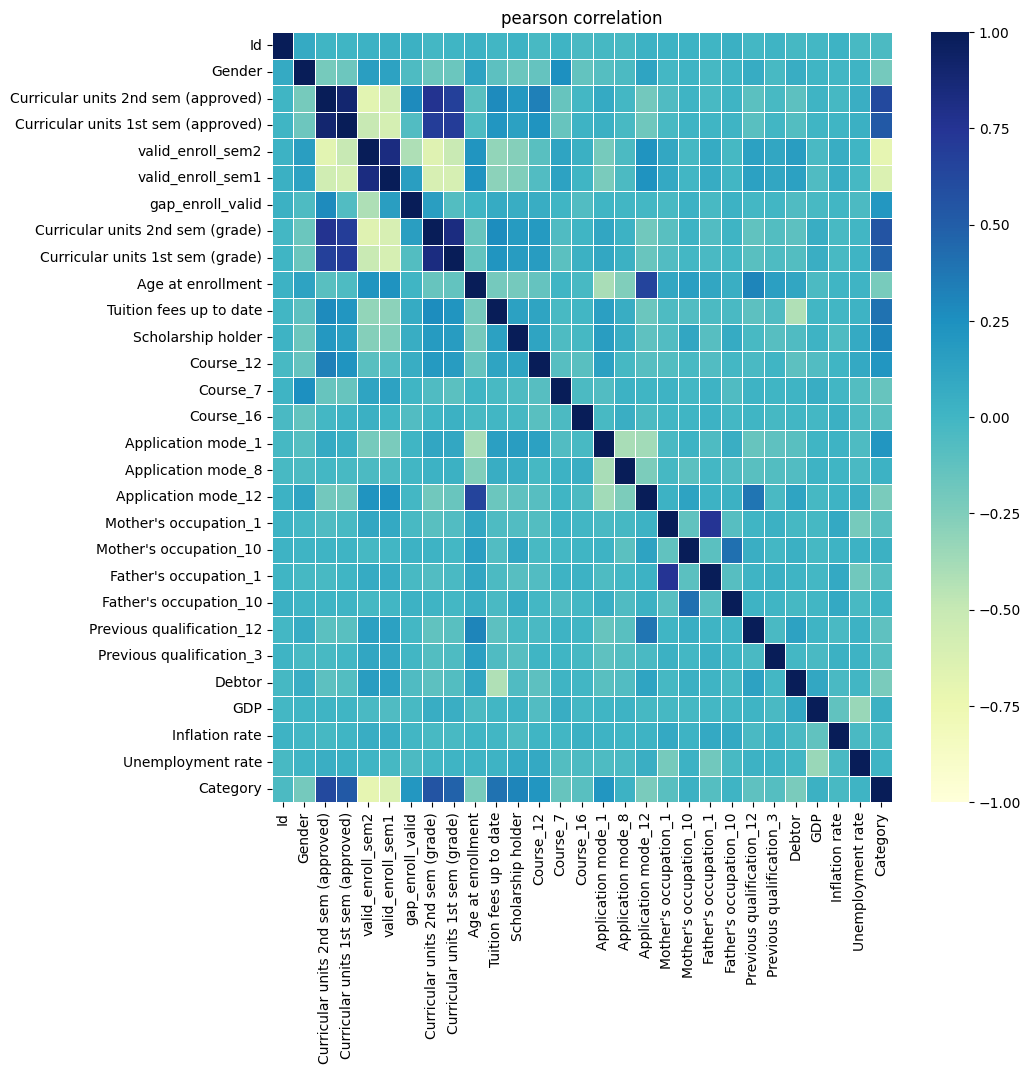

In [78]:
corr_matrix = df.copy()
for col in corr_matrix.columns:
    if corr_matrix[col].dtype == "O":
         corr_matrix[col] = corr_matrix[col].factorize(sort=True)[0]
corr_matrix = corr_matrix.corr(method="pearson")
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=False, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("pearson correlation")

# TRAIN THE MODEL

In [83]:
X_names = ["Gender",
"Curricular units 2nd sem (approved)", 
"Curricular units 1st sem (approved)",
"valid_enroll_sem2",
"valid_enroll_sem1", 
"gap_enroll_valid",
"Curricular units 2nd sem (grade)",
"Curricular units 1st sem (grade)",
"Age at enrollment",
"Tuition fees up to date",
"Scholarship holder", 
"Course_12",
"Course_7",
"Course_16",
"Application mode_1",
"Application mode_8",
"Application mode_12",
"Mother's occupation_1",
"Mother's occupation_10",
"Father's occupation_1",
"Father's occupation_10",
"Previous qualification_12",
"Previous qualification_3",
"Debtor",
"GDP",
"Inflation rate",
"Unemployment rate"
]

X_train = dfs[X_names].values
y_train = dfs["Category"].values

## call model
model = ensemble.GradientBoostingClassifier()
## define hyperparameters combinations to try
param_dic = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001],      #weighting factor for the corrections by new trees when added to the model
'n_estimators':[100,250,500,750,1000,1250,1500,1750],  #number of trees added to the model
'max_depth':[2,3,4,5,6,7],    #maximum depth of the tree
'min_samples_split':[2,4,6,8,10,20,40,60,100],    #sets the minimum number of samples to split
'min_samples_leaf':[1,3,5,7,9],     #the minimum number of samples to form a leaf
'max_features':[1,2,3,4,5,6,7],     #square root of features is usually a good starting point
'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]}       #the fraction of samples to be used for fitting the individual base learners. Values lower than 1 generally lead to a reduction of variance and an increase in bias.
## random search
random_search = model_selection.RandomizedSearchCV(model, 
       param_distributions=param_dic, n_iter=10, 
       scoring="accuracy").fit(X_train, y_train)
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean accuracy:", random_search.best_score_)
model = random_search.best_estimator_

Best Model parameters: {'subsample': 0.7, 'n_estimators': 250, 'min_samples_split': 60, 'min_samples_leaf': 3, 'max_features': 3, 'max_depth': 3, 'learning_rate': 0.05}
Best Model mean accuracy: 0.7855506679700228


## Validation test

In [84]:
## train
# model.fit(X_train, y_train)
# save the model to disk
filename = 'finalized_model_academic_V12.sav'
pickle.dump(model, open(filename, 'wb'))

In [108]:
# validation

# Find the difference in columns between the two datasets
feature_difference = set(dfs) - set(dfv)

# create zero-filled matrix where the rows are equal to the number
feature_difference_df = pd.DataFrame(data=np.zeros((dfv.shape[0], len(feature_difference))), columns=list(feature_difference))
dfv = dfv.join(feature_difference_df)

#MinMax-Scaler
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(dfv.drop(["Category","Id"], axis=1))
dtf_scaled= pd.DataFrame(X, columns=dfv.drop(["Category","Id"], axis=1).columns)
dtf_scaled["Category"] = dfv["Category"]
dtf_scaled["Id"] = dfv["Id"]
dfv = dtf_scaled

#features selection
dfv = dfv[["Id",
"Gender",
"Curricular units 2nd sem (approved)", 
"Curricular units 1st sem (approved)",
"valid_enroll_sem2",
"valid_enroll_sem1", 
"gap_enroll_valid",
"Curricular units 2nd sem (grade)",
"Curricular units 1st sem (grade)",
"Age at enrollment",
"Tuition fees up to date",
"Scholarship holder", 
"Course_12",
"Course_7",
"Course_16",
"Application mode_1",
"Application mode_8",
"Application mode_12",
"Mother's occupation_1",
"Mother's occupation_10",
"Father's occupation_1",
"Father's occupation_10",
"Previous qualification_12",
"Previous qualification_3",
"Debtor",
"GDP",
"Inflation rate",
"Unemployment rate",
"Category"]]

#Validation score see

X_validation = dfv[[
"Gender",
"Curricular units 2nd sem (approved)", 
"Curricular units 1st sem (approved)",
"valid_enroll_sem2",
"valid_enroll_sem1", 
"gap_enroll_valid",
"Curricular units 2nd sem (grade)",
"Curricular units 1st sem (grade)",
"Age at enrollment",
"Tuition fees up to date",
"Scholarship holder", 
"Course_12",
"Course_7",
"Course_16",
"Application mode_1",
"Application mode_8",
"Application mode_12",
"Mother's occupation_1",
"Mother's occupation_10",
"Father's occupation_1",
"Father's occupation_10",
"Previous qualification_12",
"Previous qualification_3",
"Debtor",
"GDP",
"Inflation rate",
"Unemployment rate"
]].values
y_validation = dfv["Category"].values

# loaded_model = pickle.load(open("finalized_model_academic_V10.sav", 'rb'))
result = model.score(X_validation, y_validation)
print(result)


0.7658132530120482


## K-fold test accuracy

In [109]:
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model
from sklearn import datasets

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
lst_accu_stratified = []
  
for train_index, test_index in skf.split(X_validation, y_validation):
    X_validation_fold, x_test_fold = X_validation[train_index], X_validation[test_index]
    y_validation_fold, y_test_fold = y_validation[train_index], y_validation[test_index]
    model.fit(X_validation_fold, y_validation_fold)
    lst_accu_stratified.append(model.score(x_test_fold, y_test_fold))
  
# Print the output.
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))

List of possible accuracy: [0.7293233082706767, 0.7443609022556391, 0.8120300751879699, 0.7593984962406015, 0.7744360902255639, 0.7593984962406015, 0.8195488721804511, 0.7293233082706767, 0.7651515151515151, 0.7272727272727273]

Maximum Accuracy That can be obtained from this model is: 81.95488721804512 %

Minimum Accuracy: 72.72727272727273 %

Overall Accuracy: 76.20243791296423 %

Standard Deviation is: 0.03273742813094835


In [110]:
predicted_prob = model.predict_proba(X_validation)[:]
predicted = model.predict(X_validation)

## Accuray e AUC
accuracy = metrics.accuracy_score(y_validation, predicted)
auc = metrics.roc_auc_score(y_validation, predicted_prob, multi_class='ovr')
print("Accuracy (overall correct predictions):",  round(accuracy,2))
print("Auc:", round(auc,3))
    
## Precision e Recall
recall = metrics.recall_score(y_validation, predicted, average='weighted')
precision = metrics.precision_score(y_validation, predicted, average='weighted')
print("Recall :", round(recall,2))
print("Precision :", round(precision,2))
print("Detail:")
print(metrics.classification_report(y_validation, predicted, target_names=[str(i) for i in np.unique(y_validation)]))

Accuracy (overall correct predictions): 0.83
Auc: 0.937
Recall : 0.83
Precision : 0.83
Detail:
              precision    recall  f1-score   support

     Dropout       0.89      0.82      0.85       441
    Enrolled       0.69      0.54      0.61       245
    Graduate       0.83      0.95      0.89       642

    accuracy                           0.83      1328
   macro avg       0.80      0.77      0.78      1328
weighted avg       0.83      0.83      0.82      1328



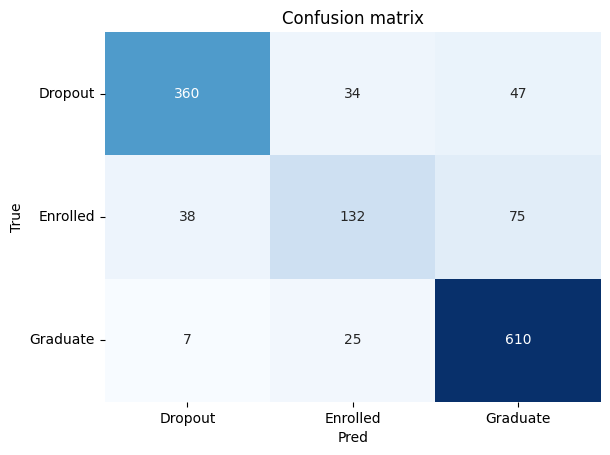

In [111]:
classes = np.unique(y_validation)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_validation, predicted, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
ax.set_xticklabels(labels=classes, rotation=0)
plt.show()

In [112]:
## calculate scores for different thresholds
dic_scores = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[]}
XX_train, XX_test, yy_train, yy_test = model_selection.train_test_split(X_train, y_train, test_size=0.2)
predicted_prob = model.fit(XX_train, yy_train).predict_proba(XX_test)[:,1]
thresholds = []
for threshold in np.arange(0.1, 1, step=0.1):
    predicted = (predicted_prob > threshold)
    thresholds.append(threshold)
dic_scores["accuracy"].append(metrics.accuracy_score(yy_test, predicted, average='weighted'))
dic_scores["precision"].append(metrics.precision_score(yy_test, predicted, average='weighted'))
dic_scores["recall"].append(metrics.recall_score(yy_test, predicted, average='weighted'))
dic_scores["f1"].append(metrics.f1_score(yy_test, predicted, average='weighted'))
        
## plot
dtf_scores = pd.DataFrame(dic_scores).set_index(pd.Index(thresholds))    
dtf_scores.plot(ax=ax, title="Threshold Selection")
plt.show()

TypeError: accuracy_score() got an unexpected keyword argument 'average'